Porto Seguro's Safe Driver Prediction
====

## Introduction
[This competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data) is hosted by the third largest insurance company in Brazil: Porto Seguro with the task of predicting the probability that a driver will initiate an insurance claim in the next year.

In the train data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. **Values of -1 indicate that the feature was missing** from the observation. The target columns signifies whether or not a claim was filed for that policy holder

train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.


In [0]:
# Import libraries
# Your code here
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


Download library for unzip *.7z

In [0]:
!apt-get install p7zip-full
!p7zip -d train.7z


Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 17022819 bytes (17 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 17022819
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%     14% - train.csv                 28% - train.csv                 42% - train.csv                 55% - train.csv                 67% - train.csv                 7

In [0]:
# Read csv file and take a look at it
train = pd.read_csv('./train.csv')


In [0]:
# print some first rows of dataset
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [0]:
# Taking a look at how many rows and columns the train dataset contains
rows = len(train) # Your code here
columns = len(train.columns) # Your code here
print("The train dataset contains {} rows and {} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [0]:
# convert category data

for i in filter(lambda x: '_cat' in x, train.columns):
  train[i] = train[i].astype('category')

## 1. Data Quality Checks

### Null or missing values check
Let check whether there are any null values in the train dataset as follows:

In [0]:
# Your code here
train.isna().any().any()

False

**Note:** Our null values check returns False but however, this does not really mean that this case has been closed as the data is also described as *"Values of -1 indicate that the feature was missing from the observation"*. Therefore I take it that Porto Seguro has simply conducted a blanket replacement of all null values in the data with the value of -1. Let us now inspect if there where any missing values in the data.

Here we can see that which columns contained -1 in their values so we could easily for example make a blanket replacement of all -1 with nulls first as follows:

In [0]:
train_copy = train.copy()
train_copy = train_copy.replace(-1, np.NaN)

We can use "Missingno" to visualize missing values in the dataset.

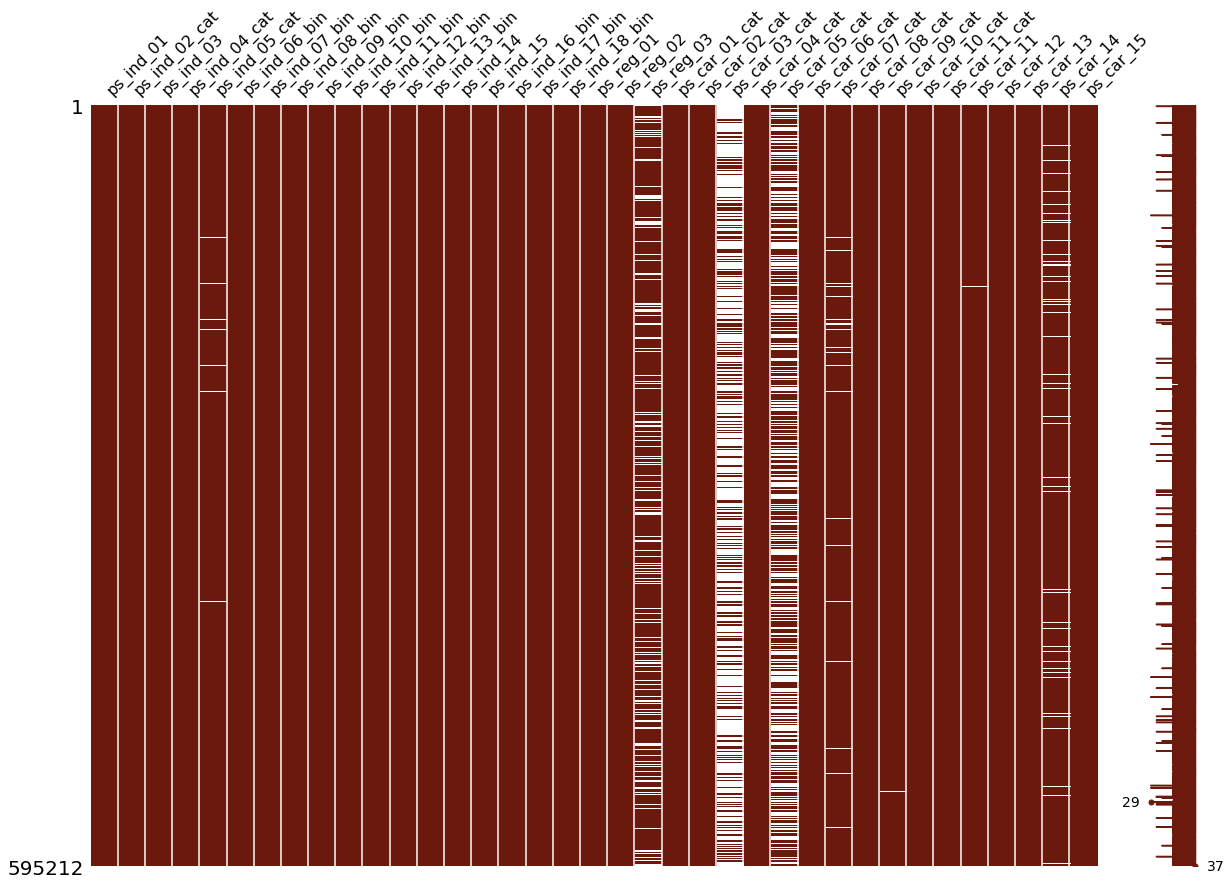

In [0]:
# If you don't have "Missingno" package, use this command to install
# (Linux) conda install -c conda-forge missingno
import missingno as msno

msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

In [0]:
# List null columns name
# Hint: isnull()
# Your code here
num_null = train_copy.isnull().sum()
num_null[num_null > 0].sort_values()

ps_car_12             1
ps_car_02_cat         5
ps_car_11             5
ps_ind_04_cat        83
ps_car_01_cat       107
ps_ind_02_cat       216
ps_car_09_cat       569
ps_ind_05_cat      5809
ps_car_07_cat     11489
ps_car_14         42620
ps_reg_03        107772
ps_car_05_cat    266551
ps_car_03_cat    411231
dtype: int64

#### Target variable inspection

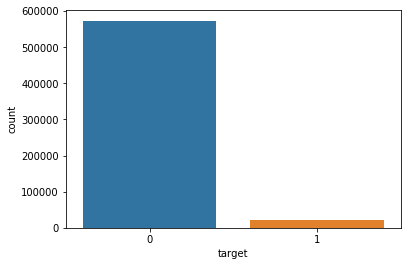

In [0]:
# Using countplot to represent target
# Your code here

sns.countplot(x = 'target', data = train_copy)

## 2. Feature inspection and filtering

### Correlation plots
As a starter, let us generate some linear correlation plots just to have a quick look at how a feature is linearly correlated to the next and perhaps start gaining some insights from here. At this juncture, I will use the seaborn statistical visualisation package to plot a heatmap of the correlation values. Conveniently, Pandas dataframes come with the corr() method inbuilt, which calculates the Pearson correlation. Also as convenient is Seaborn's way of invoking a correlation plot. Just literally the word "heatmap"

#### Correlation of float features

In [0]:
train_float = train.select_dtypes(include=['float64']) ###
train_int = train.select_dtypes(include=['int64'])     ###

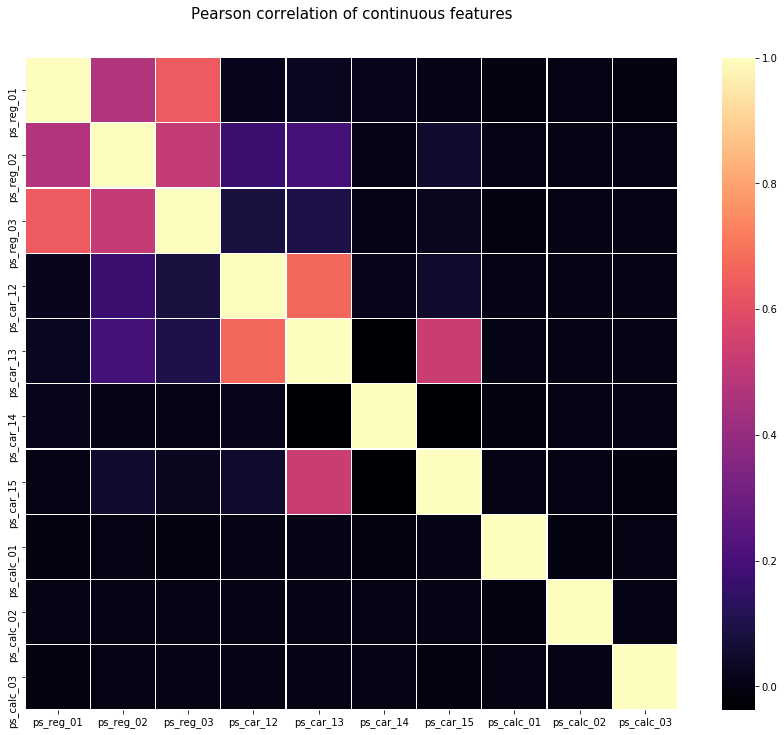

In [0]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title("Pearson correlation of continuous features", y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap=colormap)
plt.show()

From the correlation plot, we can see that the majority of the features display zero or no correlation to one another. This is quite an interesting observation that will warrant our further investigation later down. For now, the paired features that display a positive linear correlation are listed as follows:

(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)

### Correlation of integer features

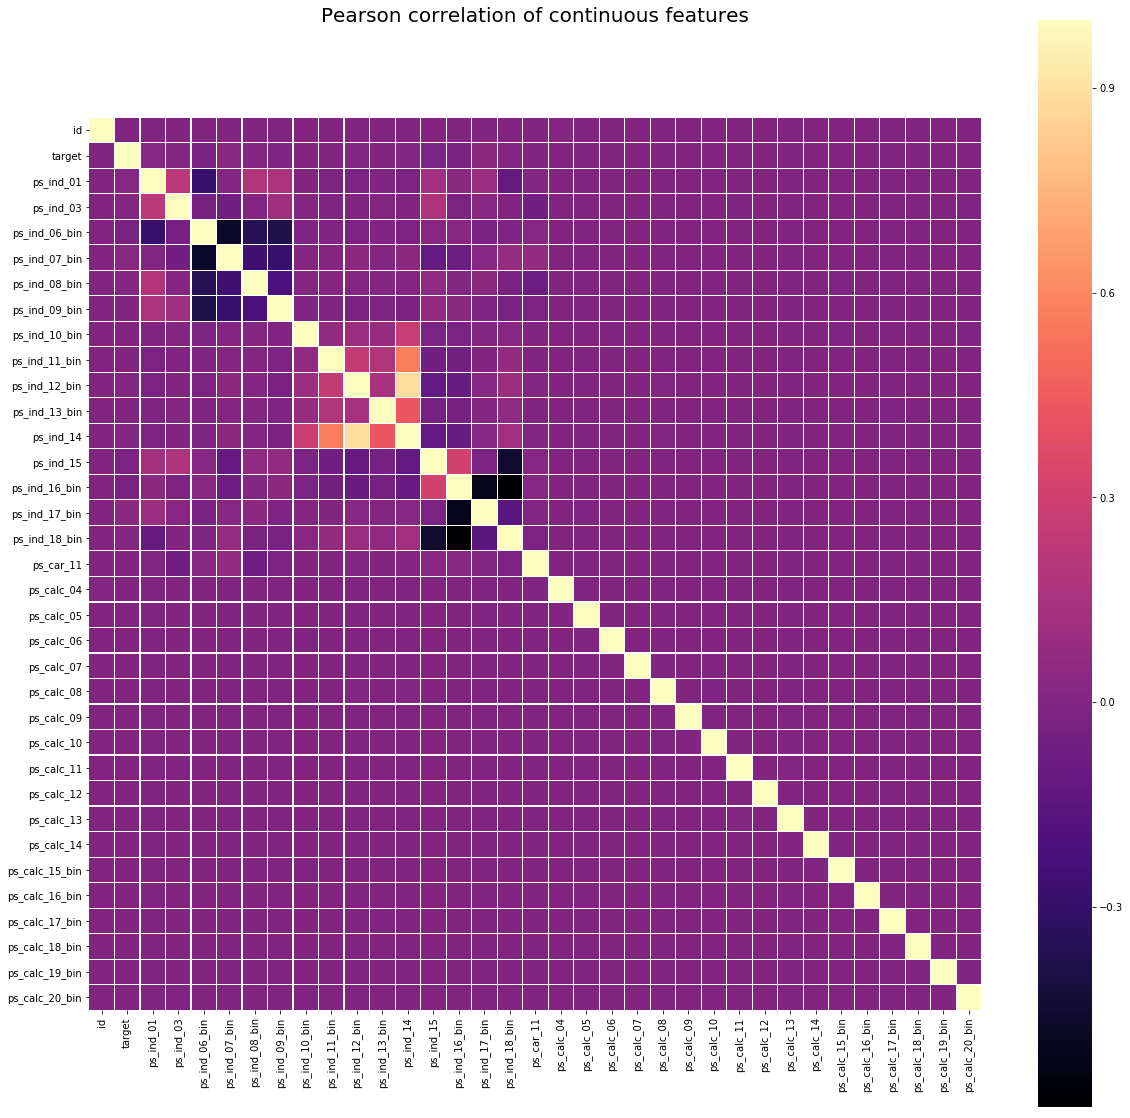

In [0]:
# Your code here
# Hint: correlation of train_int
colormap = plt.cm.magma
plt.figure(figsize=(20, 20))
plt.title("Pearson correlation of continuous features", y=1.1, size=20)
sns.heatmap(train_int.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap=colormap)
plt.show()

#### Which features have negatively correlation?
Negatively correlated features : 
(ps_ind_16_bin, ps_ind_17_bin)
(ps_ind_16_bin, ps_ind_18_bin)
(ps_ind_15, ps_ind_18_bin)


### Binary features inspection
Another aspect of the data that we may want to inspect would be the coulmns that only contain binary valeus, i.e where values take on only either of the two values 1 or 0. Proceeding, we store all columns that contain these binary values and then generate a vertical plotly bar plot of these binary values as follows:

In [0]:
bin_col = list(filter(lambda x: '_bin' in x, train.columns))
bin_value_counts = train[bin_col].apply(pd.value_counts)

In [0]:
bin_value_counts

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,360852,442223,497644,484917,594990,594205,589594,594648,201882,523143,503879,522342,221514,265356,424278,387469,503955
1,234360,152989,97568,110295,222,1007,5618,564,393330,72069,91333,72870,373698,329856,170934,207743,91257


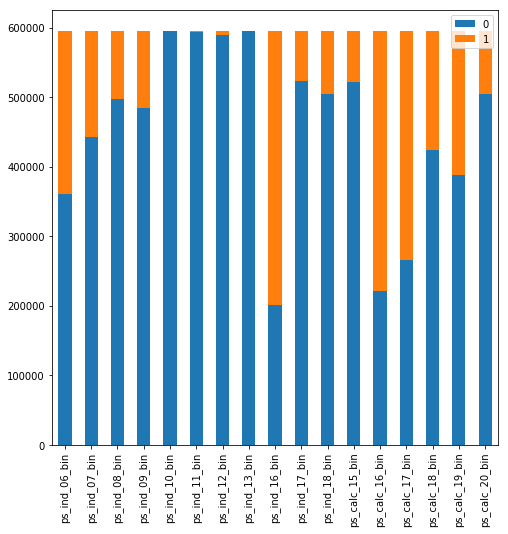

In [0]:
# hint pandas plot.bar with stacked=True
# Your code here

bin_value_counts.T.plot.bar(stacked = True, figsize = (8, 8))

Those columns ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin which are completely dominated by zeros. They do not contain much information.

## 3. Preprocess Data

In [0]:
train = pd.get_dummies(train, columns = train.select_dtypes('category').columns)

In [0]:
# Import train_test_split 
# Your code here
from sklearn.model_selection import train_test_split

In [0]:
# Define X (features), y (target)
X = train.drop(columns = ['target','id'])
y = train['target'] # Your code here

In [0]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [0]:
training_data = pd.concat([X_train, y_train], axis = 1)

In [0]:
training_data['target'].value_counts()

0    401433
1     15215
Name: target, dtype: int64


#### Randomly Under-Sampling the Training Dataset¶
**Note:** Validate ratio between 2 class after Under-Sampling

In [0]:
from sklearn.utils import resample

target_data = training_data[training_data['target'] == 1]

non_target_data = training_data[training_data['target'] == 0]

non_target_downsampled = resample(
    non_target_data,
    replace = False,
    n_samples = len(target_data),
    random_state = 1
)

total_records = len(non_target_downsampled) + len(target_data)

# Showing ratio
print("Percentage of target: ", len(target_data) / total_records)
print("Percentage of non target: ", len(non_target_downsampled) / total_records)
print("Total number of transactions in resampled data: ", len(target_data) + len(non_target_downsampled) )

under_sample_data = pd.concat([non_target_downsampled, target_data])

# Assigning X,y for Under-sampled Data
X_train_undersample = under_sample_data.drop(columns = 'target') 
y_train_undersample = under_sample_data.target

Percentage of target:  0.5
Percentage of non target:  0.5
Total number of transactions in resampled data:  30430


#### Randomly Over-Sampling the Training Dataset
**Note:** Validate ratio between 2 class after Over-Sampling

In [0]:
from sklearn.utils import resample

target_data = training_data[training_data['target'] == 1]

non_target_data = training_data[training_data['target'] == 0]

target_oversampled = resample(
    non_target_data,
    replace = True,
    n_samples = len(non_target_data),
    random_state = 1
)

total_records = len(target_oversampled) + len(non_target_data)

# Showing ratio
print("Percentage of target: ", len(target_oversampled) / total_records)
print("Percentage of non target: ", len(non_target_data) / total_records)
print("Total number of transactions in resampled data: ", len(non_target_data) + len(target_oversampled) )

over_sample_data = pd.concat([non_target_downsampled, target_data])

# Assigning X,y for Under-sampled Data
X_train_oversample = under_sample_data.drop(columns = 'target') 
y_train_oversample = under_sample_data.target

Percentage of target:  0.5
Percentage of non target:  0.5
Total number of transactions in resampled data:  802866


## 4. Modeling

In [0]:
# Spot check with LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, BernoulliNB, GaussianNB
# Import libraries and and create model

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB


lr = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
bnb = BernoulliNB()
gnb = GaussianNB()

models = [lr, dtc, rfc, gnb, bnb]
models_name = ["Logistic Regression", "Decision Tree", "Random Forest", "Bernoulli NB", "Gaussian NB"]

## 5. Evaluation Metrics

In [0]:
# Import confusion_matrix, classification_report
# Your code here
from sklearn.metrics import confusion_matrix, classification_report

# We create an utils function, that take a trained model as argument and print out confusion matrix
# classification report base on X and y
def evaluate_model(estimator, X, y):
    y_pred = estimator.predict(X)
    print('========== Confusion matrix ===============')
    print(confusion_matrix(y, y_pred))
    print('========== Classification report===========')
    print(classification_report(y, y_pred))
    return True

### Evaluate with Origin dataset

In [0]:
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Origin dataset
    model.fit(X_train,y_train)
    # Evaluate model with X_test, y_test
    evaluate_model(model, X_test, y_test)
    print("=======================================")

Model: Logistic Regression


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


========== Confusion matrix ===============
[[172083      2]
 [  6475      4]]
========== Classification report===========
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172085
           1       0.67      0.00      0.00      6479

    accuracy                           0.96    178564
   macro avg       0.82      0.50      0.49    178564
weighted avg       0.95      0.96      0.95    178564

Model: Decision Tree
========== Confusion matrix ===============
[[164042   8043]
 [  6069    410]]
========== Classification report===========
              precision    recall  f1-score   support

           0       0.96      0.95      0.96    172085
           1       0.05      0.06      0.05      6479

    accuracy                           0.92    178564
   macro avg       0.51      0.51      0.51    178564
weighted avg       0.93      0.92      0.93    178564

Model: Random Forest


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


========== Confusion matrix ===============
[[172079      6]
 [  6475      4]]
========== Classification report===========
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172085
           1       0.40      0.00      0.00      6479

    accuracy                           0.96    178564
   macro avg       0.68      0.50      0.49    178564
weighted avg       0.94      0.96      0.95    178564

Model: Bernoulli NB
========== Confusion matrix ===============
[[132235  39850]
 [  4232   2247]]
========== Classification report===========
              precision    recall  f1-score   support

           0       0.97      0.77      0.86    172085
           1       0.05      0.35      0.09      6479

    accuracy                           0.75    178564
   macro avg       0.51      0.56      0.47    178564
weighted avg       0.94      0.75      0.83    178564

Model: Gaussian NB
========== Confusion matrix ===============
[[167555   4530]


### Evaluate with *Undersampled* dataset

In [0]:
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Undersampled dataset
    model.fit(X_train_undersample, y_train_undersample)
    # Evaluate model with X_test, y_test
    evaluate_model(model, X_test, y_test)
    print("=======================================")

Model: Logistic Regression


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


========== Confusion matrix ===============
[[106260  65825]
 [  2812   3667]]
========== Classification report===========
              precision    recall  f1-score   support

           0       0.97      0.62      0.76    172085
           1       0.05      0.57      0.10      6479

    accuracy                           0.62    178564
   macro avg       0.51      0.59      0.43    178564
weighted avg       0.94      0.62      0.73    178564

Model: Decision Tree
========== Confusion matrix ===============
[[89898 82187]
 [ 3040  3439]]
========== Classification report===========
              precision    recall  f1-score   support

           0       0.97      0.52      0.68    172085
           1       0.04      0.53      0.07      6479

    accuracy                           0.52    178564
   macro avg       0.50      0.53      0.38    178564
weighted avg       0.93      0.52      0.66    178564

Model: Random Forest
========== Confusion matrix ===============
[[111687  60398]
 

### Evaluate with *Oversampled* dataset

In [0]:
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Oversampled dataset
    model.fit(X_train_oversample, y_train_oversample)
    # Evaluate model with X_test, y_test
    evaluate_model(model, X_test, y_test)
    print("=======================================")

Model: Logistic Regression


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


========== Confusion matrix ===============
[[106260  65825]
 [  2812   3667]]
========== Classification report===========
              precision    recall  f1-score   support

           0       0.97      0.62      0.76    172085
           1       0.05      0.57      0.10      6479

    accuracy                           0.62    178564
   macro avg       0.51      0.59      0.43    178564
weighted avg       0.94      0.62      0.73    178564

Model: Decision Tree
========== Confusion matrix ===============
[[89986 82099]
 [ 3079  3400]]
========== Classification report===========
              precision    recall  f1-score   support

           0       0.97      0.52      0.68    172085
           1       0.04      0.52      0.07      6479

    accuracy                           0.52    178564
   macro avg       0.50      0.52      0.38    178564
weighted avg       0.93      0.52      0.66    178564

Model: Random Forest
========== Confusion matrix ===============
[[113193  58892]
 

### Conclusion

##Which model has lowest/highest accuracy? </br>
Model Bernoulli NB has highest accuracy </br>
Model Decision Tree has lowest accuracy
##Which model has lowest/highest recall? </br>
Model Gaussian NB, Logistic Regression has highest recall </br>
Model Decision Tree has lowest recall
##Which model has lowest/highest f1? </br>
Model Gaussian NB has highest f1 score </br>
Model Decision Tree has lowest f1 score

## 6. GridsearchCV

In [0]:
# Using gridsearchcv, random forest model and this param grid to find the best combination of parameters 
# Hint: example
# https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit

from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)


#### which is the best combination of parameter

In [0]:
print(CV_rfc.best_params_)

# Done! Great Job.